In [13]:
# The associated code for the paper Anomaly Detection Using Multivariate Analysis. The goal of this project is to use 
#Principal Component Analysis for feature extraction and dimensionality reduction in combination with implementing
#Mahalanobis distance to be used as a distance metric for anomaly detection.

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [14]:
#Data ingestion was done this way to allow for multiple files to be loaded and concatenated into a single file
data_dir = 'Dataverse'
merged_data = pd.DataFrame()

In [15]:
for filename in os.listdir(data_dir):
    print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep=',', float_precision='high')
   # dataset_mean_abs = np.array(dataset.abs().mean())
   # dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,12))
   # merged_data = merged_data.append(dataset_mean_abs)
merged_data = dataset

combed.csv


In [16]:
#merged_data.columns = ['time', 'V','I','f','DPF','APF','P','Pt','Q','Qt','S','St']
merged_data.head()

,time,energy,power,current,hour_sin,hour_cos,day_sin,day_cos,week_sin,week_cos
0,2014-06-02 07:56:23,0.000000,0.694100,0.688114,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
1,2014-06-02 07:56:53,0.000019,0.714005,0.706112,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
2,2014-06-02 07:57:23,0.000037,0.695739,0.690100,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
3,2014-06-02 07:57:53,0.000057,0.695680,0.690884,0.933580,-0.358368,0.207912,0.978148,0.974928,-0.222521
4,2014-06-02 07:58:23,0.000075,0.754291,0.739050,0.932008,-0.362438,0.207912,0.978148,0.974928,-0.222521


<AxesSubplot:>

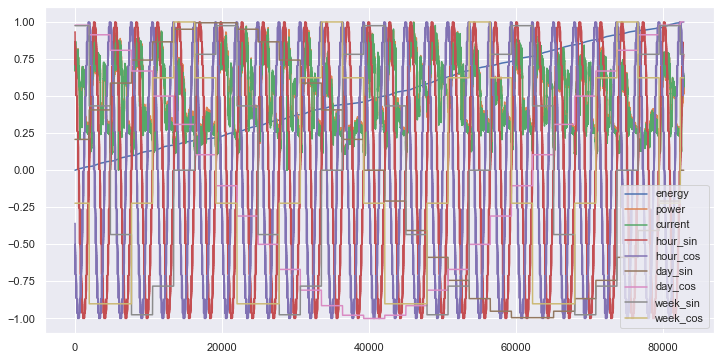

In [17]:
merged_data.plot(figsize = (12,6))

In [18]:
#Setting the time column as the index for the pandas dataframe
merged_data['time'] = pd.to_datetime(merged_data['time'])
merged_data = merged_data.sort_index()
merged_data.set_index('time', inplace=True)

<AxesSubplot:xlabel='time'>

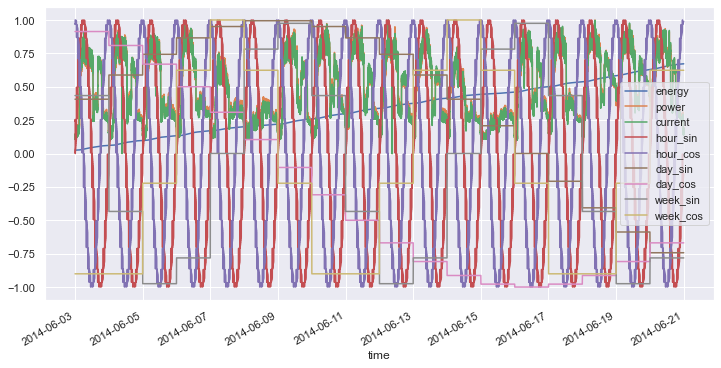

In [19]:
#Exploratory visulization of the variables, splitting of the train and test sets
dataset_train = merged_data['2014-06-03 00:00:00':'2014-06-21 00:00:00']
dataset_test = merged_data['2014-06-21 00:00:00':'2014-06-27 00:00:00']
dataset_train.plot(figsize = (12,6))

In [20]:
#Dataset normalization

scaler = preprocessing.MinMaxScaler()
#normalized_df=(merged_data-merged_data.min())/(merged_dat-a.max()-merged_data.min())
#normalized_df=(data-data.mean())/data.std()
X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                              columns=dataset_train.columns, 
                              index=dataset_train.index)


X_train.sample(frac=1)
X_test = pd.DataFrame(scaler.fit_transform(dataset_test), 
                              columns=dataset_test.columns, 
                              index=dataset_test.index)



In [7]:
X_train = dataset_train
X_test = dataset_test

In [8]:
#Method for calculating the covariance matrix, input is a Pandas dataframe. Returns the covariance matrix and the inverse covariance matrix.
def covmatrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
        
     

In [9]:
#Method for calculating the Mahalanobis distance. Takes the inverse covariance matrix, the mean distribution of the data, and the data as input
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [10]:
#Method for using Mahalanobis distance to detect outliers, input is calculated Mahalanobis distance for each observation
def MD_detectOutliers(dist, extreme=True, verbose=False):
    k = 2. if extreme else 3.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [11]:
#Threshold for determining the threshold for anomalies, either 2 or 3 standard deviations above the average
def MD_threshold(dist, extreme=True, verbose=False):
    k = 2. if extreme else 3.
    threshold = np.mean(dist) + (3 * np.std(dist))
    return threshold

In [12]:
#Method for determining if the inverse of the covariance matrix is positive definite
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [13]:
#Calculating the PCA values for the training set data with n components = 3

from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index


                            0         1         2
time                                             
2012-07-01 00:00:00  1.166049  0.477336  0.708039
2012-07-01 00:01:00  1.166046  0.477392  0.711048
2012-07-01 00:02:00  1.165946  0.477631  0.717083
2012-07-01 00:03:00  1.165944  0.477688  0.720059
2012-07-01 00:04:00  1.165941  0.477739  0.723044
2012-07-01 00:05:00  1.165939  0.477797  0.725986
2012-07-01 00:06:00  1.166050  0.478028  0.728283
2012-07-01 00:07:00  1.165934  0.477904  0.731861
2012-07-01 00:08:00  1.165932  0.477960  0.734766
2012-07-01 00:09:00  1.166028  0.477830  0.734622
2012-07-01 00:10:00  1.166026  0.477885  0.737500
2012-07-01 00:11:00  1.165925  0.478118  0.743426
2012-07-01 00:12:00  1.166037  0.478351  0.745623
2012-07-01 00:13:00  1.166019  0.478041  0.746076
2012-07-01 00:14:00  1.166016  0.478093  0.748907
2012-07-01 00:15:00  1.165916  0.478327  0.754763
2012-07-01 00:16:00  1.166012  0.478195  0.754521
2012-07-01 00:17:00  1.166025  0.478608  0.759696


NameError: name 'labels' is not defined

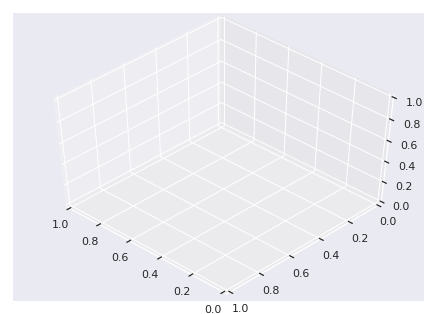

In [14]:
#Testing for visualization of the principal components, non-functional do not use

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets



plt.clf()

fig = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('I', 0), ('I', 1), ('f', 2), ('DPF', 3), ('APF', 4), ('P', 5), ('Pt', 6), ('Q', 7), ('Qt', 8), ('S', 9), ('St', 10)]:
    ax.text3D(
        X_train_PCA[labels == label, 0].mean()+ 1.5,
        X_train_PCA[labels == label, 1].mean() + 1.5,
        X_train_PCA[labels == label, 2].mean() + 1.5,
        X_train_PCA[labels == label, 3].mean() + 1.5,
        X_train_PCA[labels == label, 4].mean() + 1.5,
        X_train_PCA[labels == label, 5].mean() + 1.5,
        X_train_PCA[labels == label, 6].mean() + 1.5,
        X_train_PCA[labels == label, 7].mean() + 1.5,
        X_train_PCA[labels == label, 8].mean() + 1.5,
        X_train_PCA[labels == label, 9].mean() + 1.5,
        X_train_PCA[labels == label, 10].mean(), name,
        horizontalalignment='center',
        bbox=dict(alpha=0.5, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
labels = np.choose(labels, [1, 2, 0]).astype(np.float)
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [17]:
#Calculating the inverse covariance matrix and mean distribution of the training data, which is then used to calculate
#the Mahalanobis distance of training and test data using the inverse cov matrix and mean dist of the training data
#Then calculates the threshold for anomalies

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)
cov_matrix, inv_cov_matrix  = covmatrix(data_train)
mean_distr = data_train.mean(axis=0)
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)
print(threshold)

4.97940233507


(0.0, 30)

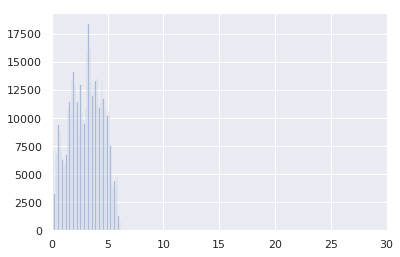

In [18]:

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 50, 
             kde= False);
plt.xlim([0.0,30])

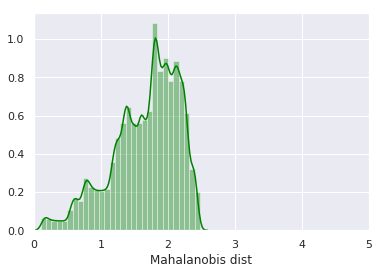

In [19]:
plt.figure()
sns.distplot(dist_train,
             bins = 30, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

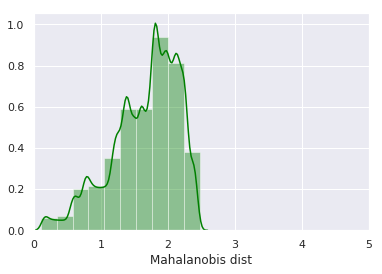

In [20]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [21]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
time,,,
2013-06-01 00:00:00,1.961660,4.979402,False
2013-06-01 00:01:00,1.963864,4.979402,False
2013-06-01 00:02:00,1.966054,4.979402,False
2013-06-01 00:03:00,1.968251,4.979402,False
2013-06-01 00:04:00,1.970443,4.979402,False


In [22]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

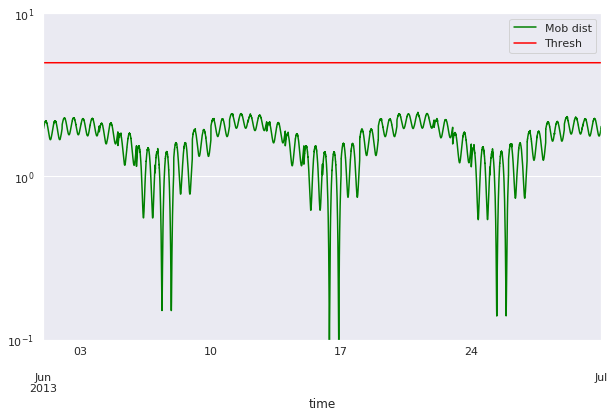

In [23]:
anomaly.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e1], color = ['green','red'])
